In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 000000_points.obj to 000000_points.obj
Saving 000001_points.obj to 000001_points.obj
Saving 000002_points.obj to 000002_points.obj
Saving 000003_points.obj to 000003_points.obj
Saving 000004_points.obj to 000004_points.obj
Saving 000005_points.obj to 000005_points.obj
Saving 000006_points.obj to 000006_points.obj
Saving 000007_points.obj to 000007_points.obj
Saving 000008_points.obj to 000008_points.obj
Saving 000009_points.obj to 000009_points.obj
Saving 000010_points.obj to 000010_points.obj
Saving 000011_points.obj to 000011_points.obj
Saving 000012_points.obj to 000012_points.obj
Saving 000013_points.obj to 000013_points.obj
Saving 000014_points.obj to 000014_points.obj
Saving 000015_points.obj to 000015_points.obj
Saving 000016_points.obj to 000016_points.obj
Saving 000017_points.obj to 000017_points.obj
Saving 000018_points.obj to 000018_points.obj
Saving 000019_points.obj to 000019_points.obj
Saving 000020_points.obj to 000020_points.obj
Saving 000021_points.obj to 000021

In [ ]:
pip install numpy scipy matplotlib trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.6/681.6 kB 10.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.spatial import KDTree
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import matplotlib.pyplot as plt

In [ ]:
# Carregar a nuvem de pontos do arquivo OBJ manualmente
def load_obj_file(filename):
    points = []
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("v "):
                _, x, y, z = line.split()
                points.append([float(x), float(y), float(z)])
    return np.array(points)

# Carregar a nuvem de pontos do arquivo OBJ usando a função customizada
point_clouds = []
for i in range(30):
    filename = f"{i:06d}_points.obj"
    point_cloud = load_obj_file(filename)
    point_clouds.append(point_cloud)

# Carregar a ground-truth do arquivo NPZ usando NumPy
ground_truth = np.load("ground_truth.npy")


In [ ]:
# Implementação do algoritmo ICP
def icp(source, target, max_iterations=100, tolerance=1e-6):
    source_tree = KDTree(source)

    T = np.eye(4)  # Estimativa inicial da matriz de transformação
    prev_error = np.inf

    for iteration in range(max_iterations):
        # Transformar a nuvem de pontos de origem usando a matriz de transformação atual
        transformed = np.dot(source, T[:3, :3].T) + T[:3, 3]

        # Encontrar os pontos mais próximos na nuvem de pontos de destino usando a estrutura KD-Tree
        distances, indices = source_tree.query(transformed)

        valid_indices = np.where(indices < len(target))[0]  # Obter apenas os índices válidos
        if len(source) != len(target[indices[valid_indices]]):
            # Lidar com o caso em que as nuvens de pontos têm dimensões diferentes
            # Por exemplo, você pode ignorar esse par de nuvens de pontos ou realizar algum tipo de tratamento adequado.
            continue

        # Atualizar a matriz de transformação usando o algoritmo ICP
        src_mean = np.mean(source, axis=0)
        tgt_mean = np.mean(target[indices[valid_indices]], axis=0)
        covariance = np.dot((source - src_mean).T, target[indices[valid_indices]] - tgt_mean)
        u, _, vh = np.linalg.svd(covariance)
        R = np.dot(u, vh)
        t = tgt_mean - np.dot(R, src_mean)
        T_new = np.eye(4)
        T_new[:3, :3] = R
        T_new[:3, 3] = t

        # Verificar a convergência comparando o erro da transformação atual com o anterior
        error = np.mean(distances[valid_indices])
        if abs(prev_error - error) < tolerance:
            break

        T = np.dot(T_new, T)
        prev_error = error

    return T


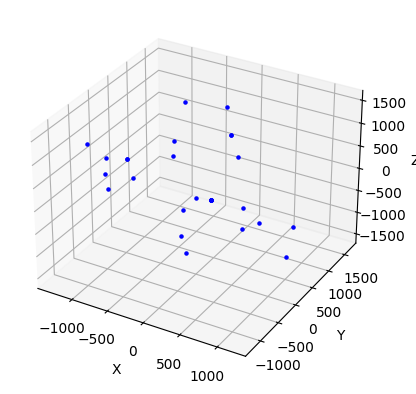

In [ ]:
# Estimar a trajetória do veículo usando o algoritmo ICP para cada par consecutivo de nuvens de pontos
trajectory = [np.eye(4)]
for i in range(1, len(point_clouds)):
    T = icp(point_clouds[i], point_clouds[i - 1])
    T = np.dot(T, trajectory[-1])  # Compor a transformação acumulada
    trajectory.append(T)

# Exibir a trajetória estimada
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for T in trajectory:
    ax.scatter(T[0, 3], T[1, 3], T[2, 3], c="b", marker=".")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
